In [ ]:
# Check GPU type
!nvidia-smi

In [ ]:
# Install ultralytics
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
!pip -q install  ultralytics
!pip install -q mlflow
!pip install seaborn
!pip install tqdm

In [ ]:
# Import libraries
import pandas as pd
import os
from pathlib import Path
import shutil
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import cv2
import yaml
import matplotlib.pyplot as plt
from ultralytics import YOLO
from ultralytics import settings
import mlflow
from PIL import Image
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
settings.update({"mlflow": True})

In [ ]:
in_colab = False
data_processed = True
eda = False
DRIVE_BASE_DIR = '/content/drive'

In [ ]:
if in_colab:
    # Mount Google Drive
    from google.colab import drive
    drive.mount(DRIVE_BASE_DIR)

In [ ]:
# Path to where your data is stored
if in_colab:
    DATA_DIR = Path('/content/drive/MyDrive/Lacuna')
else:
    DATA_DIR = Path('./')

# Preview data files available
os.listdir(DATA_DIR)

In [ ]:
# Images directories
DATASET_DIR = Path(DATA_DIR / 'datasets/dataset')
IMAGES_DIR = DATASET_DIR / 'images'
TRAIN_IMAGES_DIR = IMAGES_DIR / 'train'
VAL_IMAGES_DIR = IMAGES_DIR / 'val'
TEST_IMAGES_DIR = IMAGES_DIR / 'test'

# Labels directories
LABELS_DIR = DATASET_DIR / 'labels'
TRAIN_LABELS_DIR = LABELS_DIR / 'train'
VAL_LABELS_DIR = LABELS_DIR / 'val'
TEST_LABELS_DIR = LABELS_DIR / 'test'

In [ ]:
# URL here: https://drive.google.com/file/d/16T40TdpaB8VXohm50SySREwrzbuPcJBC/view
# !pip install gdown
# # Download the file from Google Drive using the file ID
# !gdown --id 16T40TdpaB8VXohm50SySREwrzbuPcJBC

# # Assuming the downloaded file is an image, you can move it to your desired directory
# # Replace 'downloaded_image.jpg' with the actual filename if it's different
# !mv images.zip {DATA_DIR}

## Extracting the Zipped Images

In [ ]:
if not data_processed:
  # Unzip images to 'images' dir
  shutil.unpack_archive(DATA_DIR / 'images.zip', 'images')

In [ ]:
# Load train and test files
train = pd.read_csv(DATA_DIR / 'Train.csv')
test = pd.read_csv(DATA_DIR / 'Test.csv')
ss = pd.read_csv(DATA_DIR / 'SampleSubmission.csv')

# Add an image_path column
train['image_path'] = [Path('images/' + x) for x in train.Image_ID]
test['image_path'] = [Path('images/' + x) for x in test.Image_ID]

# Map str classes to ints (label encoding targets)
train['class_id'] = train['class'].map({'Trophozoite': 0, 'WBC': 1, 'NEG': 2})

# Preview the head of the train set
train.head()

In [ ]:
# Filter out NEG class (Negative images - this images have no Trophozoite nor WBC in them)
# Yolo recommends that when creating labels for negative images, you leave them empty
# https://github.com/ultralytics/yolov5/issues/3218
# As this is a starter nb, we will ignore the negative images
train = train[~(train['class'] == 'NEG')].reset_index(drop = True)

In [ ]:
# Split data into training and validation
train_unique_imgs_df = train.drop_duplicates(subset = ['Image_ID'], ignore_index = True)
X_train, X_val = train_test_split(train_unique_imgs_df, test_size = 0.25, stratify=train_unique_imgs_df['class'], random_state=42)

X_train = train[train.Image_ID.isin(X_train.Image_ID)]
X_val = train[train.Image_ID.isin(X_val.Image_ID)]

# Check shapes of training and validation data
X_train.shape, X_val.shape

In [ ]:
# Preview target distribution, seems there a class imbalance that needs to be handled
X_train['class'].value_counts(normalize = True), X_val['class'].value_counts(normalize = True)

## Class Distribution

In [ ]:
# Create a figure with 2 subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot for the training set on the first subplot
sns.countplot(x='class', data=X_train, ax=axes[0])
axes[0].set_title('Training Set')

# Plot for the test set on the second subplot
sns.countplot(x='class', data=X_val, ax=axes[1])
axes[1].set_title('Test Set')

# Display the plots
plt.tight_layout()
plt.show()

In [ ]:
if not data_processed:
  # Check if dirs exist, if they do, remove them, otherwise create them.
  # This only needs to run once
  for DIR in [TRAIN_IMAGES_DIR,VAL_IMAGES_DIR, TEST_IMAGES_DIR, TRAIN_LABELS_DIR,VAL_LABELS_DIR,TEST_LABELS_DIR]:
    if DIR.exists():
      shutil.rmtree(DIR)
    DIR.mkdir(parents=True, exist_ok = True)

In [ ]:
if not data_processed:
  # Copy train, val and test images to their respective dirs
  for img in tqdm(X_train.image_path.unique()):
    shutil.copy(img, TRAIN_IMAGES_DIR / img.parts[-1])

  for img in tqdm(X_val.image_path.unique()):
    shutil.copy(img, VAL_IMAGES_DIR / img.parts[-1])

  for img in tqdm(test.image_path.unique()):
    shutil.copy(img, TEST_IMAGES_DIR / img.parts[-1])

In [ ]:
# Note: Run only once
# Use threadpoolexecutor as it is more stable that multiprocessing.Pool
from concurrent.futures import ThreadPoolExecutor
# Function to convert the bboxes to yolo format and save them
def save_yolo_annotation(row):
    image_path, class_id, output_dir = row['image_path'], row['class_id'], row['output_dir']

    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not read image from path: {image_path}")

    height, width, _ = img.shape

    label_file = Path(output_dir) / f"{Path(image_path).stem}.txt"

    ymin, xmin, ymax, xmax = row['ymin'], row['xmin'], row['ymax'], row['xmax']

    # Normalize the coordinates
    x_center = (xmin + xmax) / 2 / width
    y_center = (ymin + ymax) / 2 / height
    bbox_width = (xmax - xmin) / width
    bbox_height = (ymax - ymin) / height

    with open(label_file, 'a') as f:
        f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}\n")

# Use ThreadPoolExecutor instead of multiprocessing.Pool
def process_dataset(dataframe, output_dir):
    dataframe['output_dir'] = output_dir
    with ThreadPoolExecutor(max_workers=4) as executor:
        list(tqdm(executor.map(save_yolo_annotation, dataframe.to_dict('records')), total=len(dataframe)))

if not data_processed:
    # Save train and validation labels to their respective dirs
    process_dataset(X_train, TRAIN_LABELS_DIR)

In [ ]:
if not data_processed:
    process_dataset(X_val, VAL_LABELS_DIR)

In [ ]:
# Train images dir
TRAIN_IMAGES_DIR

## Dataset and Image Statistics

In [ ]:
CLASS_MAP = {0: 'Trophozoite', 1: 'WBC'}
ANNOTATIONS_PATH = DATASET_DIR / 'labels' / 'train'
IMAGES_PATH = DATASET_DIR / 'images' / 'train'

# Helper function to load annotations
def load_annotations(annotation_path):
    """Load annotations and return a DataFrame with relevant data."""
    annotation_files = [
        os.path.join(annotation_path, f) for f in os.listdir(annotation_path) if f.endswith('.txt')
    ]
    data = {'class_id': [], 'center_x': [], 'center_y': [], 'width': [], 'height': []}

    for file in annotation_files:
        with open(file, 'r') as f:
            for line in f:
                class_id, center_x, center_y, width, height = map(float, line.split())
                data['class_id'].append(int(class_id))
                data['center_x'].append(center_x)
                data['center_y'].append(center_y)
                data['width'].append(width)
                data['height'].append(height)
    return pd.DataFrame(data)

# Helper function to load image properties
def load_image_properties(image_path):
    """Extract image properties (size, aspect ratio, brightness, RGB channels)."""
    image_files = [
        os.path.join(image_path, f) for f in os.listdir(image_path) if f.endswith(('.jpg', '.png'))
    ]
    data = {
        'width': [], 'height': [], 'aspect_ratio': [],
        'mean_brightness': [], 'mean_red': [], 'mean_green': [], 'mean_blue': []
    }

    for image_file in image_files:
        with Image.open(image_file) as img:
            width, height = img.size
            data['width'].append(width)
            data['height'].append(height)
            data['aspect_ratio'].append(width / height)

            img_np = np.array(img)
            if len(img_np.shape) == 3 and img_np.shape[2] == 3:
                data['mean_red'].append(np.mean(img_np[:, :, 0]))
                data['mean_green'].append(np.mean(img_np[:, :, 1]))
                data['mean_blue'].append(np.mean(img_np[:, :, 2]))
                data['mean_brightness'].append(np.mean(img_np))
            else:
                data['mean_brightness'].append(np.mean(img_np))
                data['mean_red'].append(np.nan)
                data['mean_green'].append(np.nan)
                data['mean_blue'].append(np.nan)

    return pd.DataFrame(data)

# Helper function to map class IDs to names
def map_class_names(df, class_map):
    """Map class IDs to class names."""
    df['class'] = df['class_id'].map(class_map)
    return df

# Plotting functions
def plot_scatter_centers(df):
    """Plot the scatter plot of object centers."""
    plt.figure(figsize=(8, 8))
    sns.scatterplot(
        x='center_x', y='center_y', hue='class', data=df, palette=['blue', 'orange'], s=50
    )
    plt.title('Distribution of Object Centers')
    plt.xlabel('Normalized Center X')
    plt.ylabel('Normalized Center Y')
    plt.gca().invert_yaxis()
    plt.show()

def plot_class_distribution(df):
    """Plot the class distribution."""
    class_df = pd.DataFrame({'Class': df['class']})
    plt.figure(figsize=(6, 4))
    sns.countplot(x='Class', data=class_df)
    plt.title('Class Distribution')
    plt.show()

def plot_bounding_box_properties(df):
    """Plot bounding box properties."""
    box_widths = df['width']
    box_heights = df['height']
    aspect_ratios = box_widths / box_heights.replace(0, float('inf'))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(box_widths, bins=20, kde=True)
    plt.title('Bounding Box Widths')

    plt.subplot(1, 2, 2)
    sns.histplot(box_heights, bins=20, kde=True)
    plt.title('Bounding Box Heights')

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 4))
    sns.histplot(aspect_ratios, bins=20, kde=True)
    plt.title('Bounding Box Aspect Ratios')
    plt.show()

def plot_image_properties(df):
    """Plot image properties: size, brightness, and color channels."""
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(df['width'], bins=20, kde=True)
    plt.title('Image Widths')

    plt.subplot(1, 2, 2)
    sns.histplot(df['height'], bins=20, kde=True)
    plt.title('Image Heights')

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 6))
    sns.histplot(df['aspect_ratio'], bins=20, kde=True)
    plt.title('Aspect Ratio (Width/Height)')
    plt.show()

    plt.figure(figsize=(6, 6))
    sns.histplot(df['mean_brightness'], bins=20, kde=True)
    plt.title('Mean Brightness')
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    sns.histplot(df['mean_red'], bins=20, kde=True, color='red')
    plt.title('Mean Red Channel')

    plt.subplot(1, 3, 2)
    sns.histplot(df['mean_green'], bins=20, kde=True, color='green')
    plt.title('Mean Green Channel')

    plt.subplot(1, 3, 3)
    sns.histplot(df['mean_blue'], bins=20, kde=True, color='blue')
    plt.title('Mean Blue Channel')

    plt.tight_layout()
    plt.show()

annotation_df = load_annotations(ANNOTATIONS_PATH)
annotation_df = map_class_names(annotation_df, CLASS_MAP)

image_df = load_image_properties(IMAGES_PATH)

# Plot all EDA
plot_scatter_centers(annotation_df)
plot_class_distribution(annotation_df)
plot_bounding_box_properties(annotation_df)
plot_image_properties(image_df)


In [ ]:
# Plot some images and their bboxes to ensure the conversion was done correctly
def load_annotations(label_path):
    with open(label_path, 'r') as f:
        lines = f.readlines()
    boxes = []
    for line in lines:
        class_id, x_center, y_center, width, height = map(float, line.strip().split())
        boxes.append((class_id, x_center, y_center, width, height))
    return boxes

# Function to plot an image with its bounding boxes
def plot_image_with_boxes(image_path, boxes):
    # Load the image
    image = cv2.imread(str(image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Get image dimensions
    h, w, _ = image.shape

    # Plot the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)

    # Plot each bounding box
    for box in boxes:
        class_id, x_center, y_center, width, height = box
        # Convert YOLO format to corner coordinates
        xmin = int((x_center - width / 2) * w)
        ymin = int((y_center - height / 2) * h)
        xmax = int((x_center + width / 2) * w)
        ymax = int((y_center + height / 2) * h)

        # Draw the bounding box
        plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                          edgecolor='red', facecolor='none', linewidth=2))
        plt.text(xmin, ymin - 10, f'Class {int(class_id)}', color='red', fontsize=12, weight='bold')

    plt.axis('off')
    plt.show()


# Directories for images and labels
IMAGE_DIR = TRAIN_IMAGES_DIR
LABEL_DIR = TRAIN_LABELS_DIR

# Plot a few images with their annotations
for image_name in os.listdir(IMAGE_DIR)[:3]:
    image_path = IMAGE_DIR / image_name
    label_path = LABEL_DIR / (image_name.replace('.jpg', '.txt').replace('.png', '.txt'))

    if label_path.exists():
        boxes = load_annotations(label_path)
        print(f"Plotting {image_name} with {len(boxes)} bounding boxes.")
        plot_image_with_boxes(image_path, boxes)
    else:
        print(f"No annotations found for {image_name}.")


In [ ]:
# Load a yolo pretrained model
model = YOLO('runs/detect/train11/weights/best.pt')

In [ ]:
# # Tune hyperparameters on Lacuna for 30 epochs
# model.tune(data='data.yaml', epochs=30, iterations=300, optimizer="AdamW", plots=False, save=False, val=False)

In [ ]:
# Create a data.yaml file required by yolo
class_names = train['class'].unique().tolist()
num_classes = len(class_names)

data_yaml = {
    'train': str(TRAIN_IMAGES_DIR),
    'val': str(VAL_IMAGES_DIR),
    'test': str(TEST_IMAGES_DIR),
    'nc': num_classes,
    'names': class_names,
    'dropout': 0.1,
    # 'dropout': 0.1,
    # 'hsv_h': 0.015,            # Adjusts hue
    # 'hsv_s': 0.7,              # Adjusts saturation
    # 'hsv_v': 0.4,              # Adjusts brightness
    # 'degrees': 0.5,            # Random rotation
    # 'translate': 0.1,          # Random translation
    # 'scale': 0.5,              # Random scaling
    'shear': 0.5,              # Random shearing
    'perspective': 0.2,        # Random perspective transformation
    # 'flipud': 0.5,             # Upside-down flip probability
    # 'fliplr': 0.5,             # Left-right flip probability
    # 'bgr': 0.1,                # BGR channel flip probability
    # 'mosaic': 1.0,             # Mosaic augmentation
    # 'mixup': 0.1,              # MixUp augmentation
    # 'copy_paste': 0.0,         # Copy-Paste augmemntation
    # 'copy_paste_mode': 'flip',  # Method for Copy-Paste
    # 'auto_augment': 'randaugment',  # Automatic augmentation policy
    # 'erasing': 0.1,            # Random erasing
    # 'crop_fraction': 0.5       # Fraction for cropping

}

yaml_path = 'data.yaml'
with open(yaml_path, 'w') as file:
    yaml.dump(data_yaml, file, default_flow_style=False)

# Preview data yaml file
data_yaml

In [ ]:
# def freeze_layer(trainer):
#     model = trainer.model
#     num_freeze = 10
#     print(f"Freezing {num_freeze} layers")
#     freeze = [f'model.{x}.' for x in range(num_freeze)]  # layers to freeze
#     for k, v in model.named_parameters():
#         v.requires_grad = True  # train all layers
#         if any(x in k for x in freeze):
#             print(f'freezing {k}')
#             v.requires_grad = False
#     print(f"{num_freeze} layers are freezed.")
# Freezing Layers within the model to finetune head and neck of model
# model.add_callback("on_train_start", freeze_layer)

In [ ]:
# Fine tune model to our data
model.train(
    data='data.yaml',          # Path to the dataset configuration
    epochs=30,                 # Number of epochs
    imgsz=2048,                # Image size (height, width)
    batch=-1,                  # Allocate 60% cuda memory
    device=0,                  # Device to use (0 for the first GPU)
    patience=0,
    # augment=True,            # Whether to apply ultralytics built in image augmentation
)

In [10]:
model = YOLO('runs/detect/train/weights/best.pt')

In [ ]:
# Validate the model on the validation set
results = model.val()

4


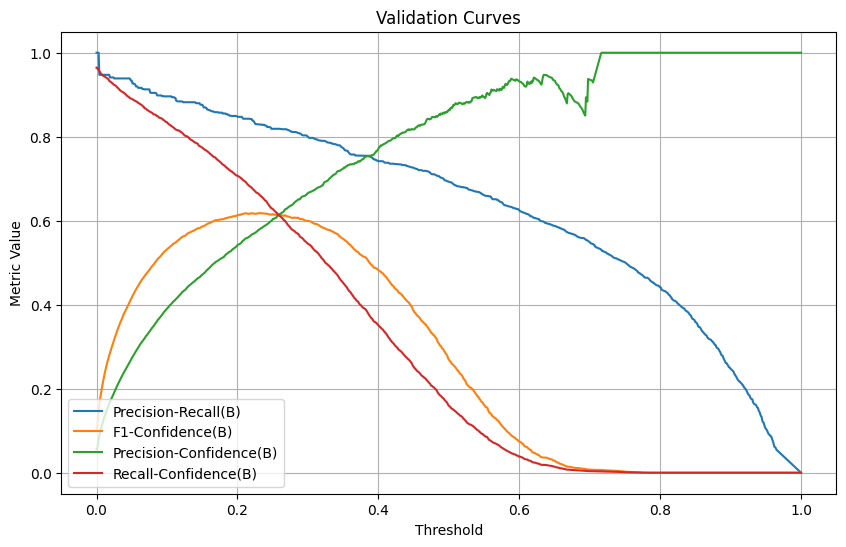

In [29]:
curves = results.curves
curves_results = results.curves_results
print(len(curves_results))
# Iterate and plot each curve
plt.figure(figsize=(10, 6))
for i, curve in enumerate(curves):
    x_values = curves_results[i][0]  # Extract x values (e.g., thresholds)
    y_values = curves_results[i][1][0]  # Extract the first metric row from y_values to match x_values
    plt.plot(x_values, y_values, label=curve)

plt.title('Validation Curves')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.legend()
plt.grid()
plt.show()


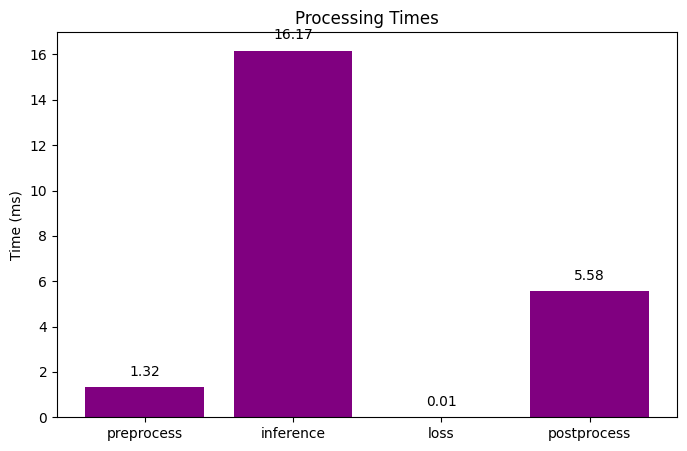

In [17]:
# Extract speed metrics
speed_metrics = results.speed
speed_labels = list(speed_metrics.keys())
speed_values = list(speed_metrics.values())

# Bar plot for speed
plt.figure(figsize=(8, 5))
plt.bar(speed_labels, speed_values, color='purple')
plt.title('Processing Times')
plt.ylabel('Time (ms)')
for i, v in enumerate(speed_values):
    plt.text(i, v + 0.5, f"{v:.2f}", ha='center')
plt.show()


In [ ]:
# Path to the test images directory
test_dir_path = DATASET_DIR / 'images' / 'test'

# Get a list of all image files in the test directory
image_files = os.listdir(test_dir_path)

# Initialize an empty list to store the results for all images
all_data = []

# Iterate through each image in the directory
for image_file in image_files:
    # Full path to the image
    img_path = os.path.join(test_dir_path, image_file)

    # Make predictions on the image
    results = model(img_path)

    # Extract bounding boxes, confidence scores, and class labels
    boxes = results[0].boxes.xyxy.tolist()  # Bounding boxes in xyxy format
    classes = results[0].boxes.cls.tolist()  # Class indices
    confidences = results[0].boxes.conf.tolist()  # Confidence scores
    names = results[0].names  # Class names dictionary
    if not boxes:
        # If no detections, add NEG as the class
        all_data.append({
            'Image_ID': image_file,
            'class': 'NEG',
            'confidence': 1.0,  # You can set this to a default value
            'ymin': 0,  # Default value (no detection)
            'xmin': 0,  # Default value (no detection)
            'ymax': 0,  # Default value (no detection)
            'xmax': 0   # Default value (no detection)
        })
    else:
        # Iterate through the results for this image
        for box, cls, conf in zip(boxes, classes, confidences):
            x1, y1, x2, y2 = box
            detected_class = names[int(cls)]  # Get the class name from the names dictionary

            # Add the result to the all_data list
            all_data.append({
                'Image_ID': image_file,
                'class': detected_class,
                'confidence': conf,
                'ymin': y1,
                'xmin': x1,
                'ymax': y2,
                'xmax': x2
            })

# Convert the list to a DataFrame for all images
sub = pd.DataFrame(all_data)

In [ ]:
sub.head()

In [ ]:
sub['class'].value_counts()

In [ ]:
# Create submission file to be uploaded to Zindi for scoring
sub.to_csv('submission.csv', index = False)